# NECESSARY LIBRARIES FOR THE PROJECT

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, silhouette_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVR
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPRegressor

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing the dataset


In [3]:
df = pd.read_csv("/content/drive/MyDrive/datasets/train_dataset.csv")
df.head()

,Restaurant,Location,Cuisines,Average_Cost,Minimum_Order,Rating,Votes,Reviews,Delivery_Time
0,ID_3744,"Dockyard Road, Mumbai CST Area","Fast Food, Chinese",₹200,₹50,3.8,91,44,45 minutes
1,ID_5984,Delhi Cantt.,North Indian,₹100,₹50,2.9,37,16,30 minutes
2,ID_13,"MG Road, Pune","Continental, North Indian, Seafood, Cafe, Sala...",₹650,₹50,4.1,3860,1962,45 minutes
3,ID_643,"Delhi Administration Flats, Timarpur",Naga,₹250,₹50,3.9,313,119,45 minutes
4,ID_5754,Pune University,"Pizza, Fast Food",₹200,₹50,3.3,86,48,45 minutes


In [4]:
df.shape

(8875, 9)

In [5]:
df.describe()

,Restaurant,Location,Cuisines,Average_Cost,Minimum_Order,Rating,Votes,Reviews,Delivery_Time
count,8875,8875,8875,8875,8875,8875,8875,8875,8875
unique,6363,35,1920,23,15,33,1024,711,7
top,ID_4625,"Mico Layout, Stage 2, BTM Layout,Bangalore",North Indian,₹200,₹50,-,-,-,30 minutes
freq,16,753,681,2594,8115,961,1676,1859,5919


In [6]:
df.isnull().sum()

,0
Restaurant,0
Location,0
Cuisines,0
Average_Cost,0
Minimum_Order,0
Rating,0
Votes,0
Reviews,0
Delivery_Time,0


In [7]:
df.duplicated(subset=['Restaurant']).sum()

np.int64(2512)

#FEATURE ENGINEERING

#Feature Selection using Correlation

In [8]:
df.dtypes

,0
Restaurant,object
Location,object
Cuisines,object
Average_Cost,object
Minimum_Order,object
Rating,object
Votes,object
Reviews,object
Delivery_Time,object


In [9]:
non_numeric = df[
    ~df['Average_Cost']
    .astype(str)
    .str.replace('₹', '', regex=False)
    .str.replace(',', '', regex=False)
    .str.strip()
    .str.isdigit()
]
print(non_numeric['Average_Cost'].unique())

['for']


In [10]:
df['Average_Cost'] = pd.to_numeric(
    df['Average_Cost']
    .astype(str)
    .str.replace('₹', '', regex=False)
    .str.replace(',', '', regex=False),
    errors='coerce'
)

In [11]:
df['Minimum_Order'] = pd.to_numeric(
    df['Minimum_Order']
    .astype(str)
    .str.replace('₹', '', regex=False)
    .str.replace(',', '', regex=False),
    errors='coerce'
)

In [12]:
df['Delivery_Time'] = pd.to_numeric(
    df['Delivery_Time']
    .astype(str)
    .str.replace(' minutes', '', regex=False),
    errors='coerce'
)

In [13]:
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
df['Votes'] = pd.to_numeric(df['Votes'], errors='coerce')
df['Reviews'] = pd.to_numeric(df['Reviews'], errors='coerce')

In [14]:
df['Rating']

,Rating
0,3.8
1,2.9
2,4.1
3,3.9
4,3.3
...,...
8870,4.3
8871,4.0
8872,3.9
8873,3.1


In [15]:
df.isnull().sum()

df.dropna(inplace=True)

In [16]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
print(numeric_cols)

Index(['Average_Cost', 'Minimum_Order', 'Rating', 'Votes', 'Reviews',
       'Delivery_Time'],
      dtype='object')


In [17]:
correlation_matrix = df[numeric_cols].corr()
print(correlation_matrix)

               Average_Cost  Minimum_Order    Rating     Votes   Reviews  \
Average_Cost       1.000000       0.119278  0.360596  0.450862  0.469100   
Minimum_Order      0.119278       1.000000  0.058710  0.132510  0.134167   
Rating             0.360596       0.058710  1.000000  0.442780  0.431590   
Votes              0.450862       0.132510  0.442780  1.000000  0.963821   
Reviews            0.469100       0.134167  0.431590  0.963821  1.000000   
Delivery_Time      0.150090       0.230495  0.129770  0.197399  0.172590   

               Delivery_Time  
Average_Cost        0.150090  
Minimum_Order       0.230495  
Rating              0.129770  
Votes               0.197399  
Reviews             0.172590  
Delivery_Time       1.000000  


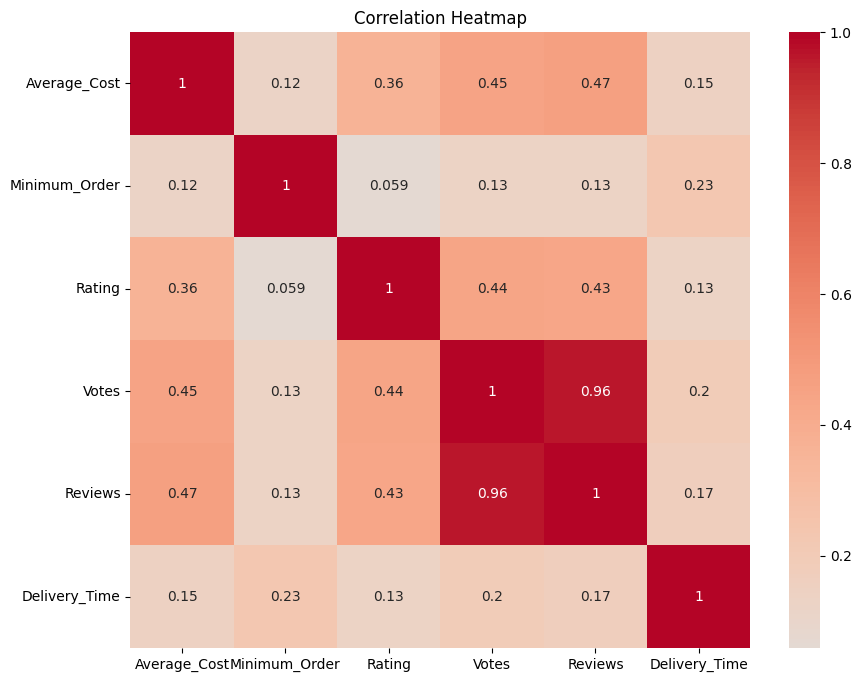

In [18]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

**Feature Selection:** Used correlation analysis to identify features most related to our target variable (Delivery_Time). Key findings:
- Removed 'Reviews' feature due to high multicollinearity with 'Votes' (correlation = 0.96)
- Kept features with meaningful correlation: Minimum_Order (0.23), Votes (0.20), Average_Cost (0.15), and Rating (0.13)
- All retained features show positive correlation with delivery time, indicating longer deliveries for popular/expensive restaurants

# Feature encoding using Label Encoding

In [19]:
categorical_cols = df.select_dtypes(include=['object']).columns
print(f"Categorical columns: {categorical_cols.tolist()}")

Categorical columns: ['Restaurant', 'Location', 'Cuisines']


In [20]:
le = LabelEncoder()

In [21]:
df['Location_Encoded'] = le.fit_transform(df['Location'])
print(f"Location encoded: {df['Location'].nunique()} unique values")

Location encoded: 35 unique values


In [22]:
df['Cuisines_Encoded'] = le.fit_transform(df['Cuisines'])
print(f"Cuisines encoded: {df['Cuisines'].nunique()} unique values")

Cuisines encoded: 1750 unique values


In [23]:
print(df[['Location', 'Location_Encoded', 'Cuisines', 'Cuisines_Encoded']].head())

                               Location  Location_Encoded  \
0        Dockyard Road, Mumbai CST Area                 9   
1                          Delhi Cantt.                 6   
2                         MG Road, Pune                15   
3  Delhi Administration Flats, Timarpur                 5   
4                       Pune University                24   

                                            Cuisines  Cuisines_Encoded  
0                                 Fast Food, Chinese               719  
1                                       North Indian              1137  
2  Continental, North Indian, Seafood, Cafe, Sala...               635  
3                                               Naga              1133  
4                                   Pizza, Fast Food              1521  


In [24]:
df_encoded = df.drop(columns=['Location', 'Cuisines'])
print(f"Final columns: {df_encoded.columns.tolist()}")

Final columns: ['Restaurant', 'Average_Cost', 'Minimum_Order', 'Rating', 'Votes', 'Reviews', 'Delivery_Time', 'Location_Encoded', 'Cuisines_Encoded']


**Feature Encoding:** Applied Label Encoding to categorical variables (Location and Cuisines) to convert them into numerical format suitable for machine learning models. Location was encoded into 35 unique numerical values and Cuisines into 1920 unique categories, enabling algorithms to process these features effectively.

#Feature scaling using StandardScaler

In [25]:
scaler = StandardScaler()

In [26]:
features_to_scale = ['Average_Cost', 'Minimum_Order', 'Rating', 'Votes',
                     'Location_Encoded', 'Cuisines_Encoded']

In [27]:
df_encoded[features_to_scale] = scaler.fit_transform(df_encoded[features_to_scale])

In [28]:
print(df_encoded[features_to_scale].head())

   Average_Cost  Minimum_Order    Rating     Votes  Location_Encoded  \
0     -0.111474       -0.20914  0.410115 -0.289478         -0.843711   
1     -0.837995       -0.20914 -1.785044 -0.382026         -1.158839   
2      3.157872       -0.20914  1.141834  6.170014         -0.213454   
3      0.251787       -0.20914  0.654021  0.090996         -1.263882   
4     -0.111474       -0.20914 -0.809418 -0.298048          0.731931   

   Cuisines_Encoded  
0         -0.409865  
1          0.434640  
2         -0.579575  
3          0.426559  
4          1.210454  


#Visualization

/tmp/ipython-input-2785221261.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot([df['Average_Cost'], df['Minimum_Order'], df['Rating']],
/tmp/ipython-input-2785221261.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot([df_encoded['Average_Cost'], df_encoded['Minimum_Order'], df_encoded['Rating']],


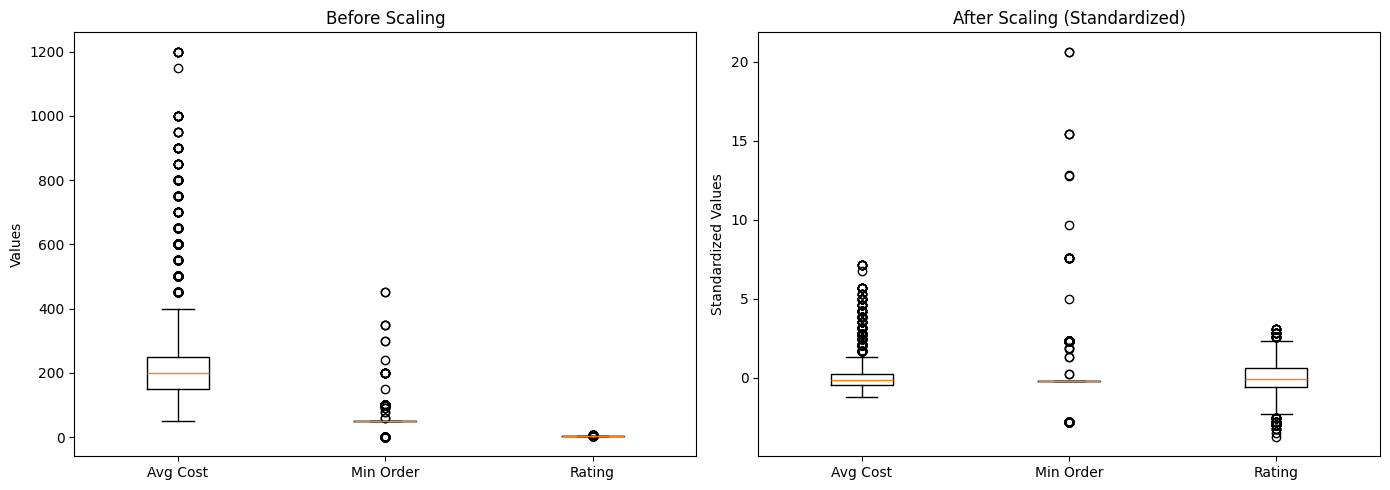

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].boxplot([df['Average_Cost'], df['Minimum_Order'], df['Rating']],
                labels=['Avg Cost', 'Min Order', 'Rating'])
axes[0].set_title('Before Scaling')
axes[0].set_ylabel('Values')

axes[1].boxplot([df_encoded['Average_Cost'], df_encoded['Minimum_Order'], df_encoded['Rating']],
                labels=['Avg Cost', 'Min Order', 'Rating'])
axes[1].set_title('After Scaling (Standardized)')
axes[1].set_ylabel('Standardized Values')

plt.tight_layout()
plt.show()

**Feature Scaling:** Applied StandardScaler to normalize all numeric features (Average_Cost, Minimum_Order, Rating, Votes, Location_Encoded, Cuisines_Encoded) to have mean ≈ 0 and standard deviation ≈ 1. This standardization ensures all features are on the same scale, preventing features with larger ranges from dominating the model and improving performance of distance-based algorithms like KNN, SVM, and Neural Networks.

#TRAIN - TEST  SPLIT

#Preparing the Data

In [30]:
X = df_encoded.drop(columns=['Restaurant', 'Delivery_Time'])
y = df_encoded['Delivery_Time']

In [31]:
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

Features shape: (7016, 7)
Target shape: (7016,)


In [32]:
print(f"Feature columns: {X.columns.tolist()}")

Feature columns: ['Average_Cost', 'Minimum_Order', 'Rating', 'Votes', 'Reviews', 'Location_Encoded', 'Cuisines_Encoded']


#Train-Test Split

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=00)

In [34]:
print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

Training set size: 5612
Testing set size: 1404


#Train Multiple Models

In [35]:
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42, n_estimators=100),
    'KNN': KNeighborsRegressor(n_neighbors=5),
    'SVR': SVR(kernel='rbf')
}

In [36]:
results = []

In [37]:
for model_name, model in models.items():

    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    train_r2 = r2_score(y_train, y_train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

    y_test_pred = model.predict(X_test)
    test_r2 = r2_score(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

    results.append({
        'Model': model_name,
        'Train R² Score': round(train_r2, 4),
        'Test R² Score': round(test_r2, 4),
        'Train RMSE': round(train_rmse, 2),
        'Test RMSE': round(test_rmse, 2)
    })

    print(f"{model_name} completed")

Linear Regression completed
Decision Tree completed
Random Forest completed
KNN completed
SVR completed


#Create Results Table

In [38]:
results_df = pd.DataFrame(results)
print(results_df)

               Model  Train R² Score  Test R² Score  Train RMSE  Test RMSE
0  Linear Regression          0.0945         0.1062       12.43      12.40
1      Decision Tree          1.0000        -0.4041        0.00      15.54
2      Random Forest          0.9062         0.3044        4.00      10.94
3                KNN          0.3898         0.0754       10.20      12.61
4                SVR         -0.0443        -0.0217       13.35      13.25


#Visualization

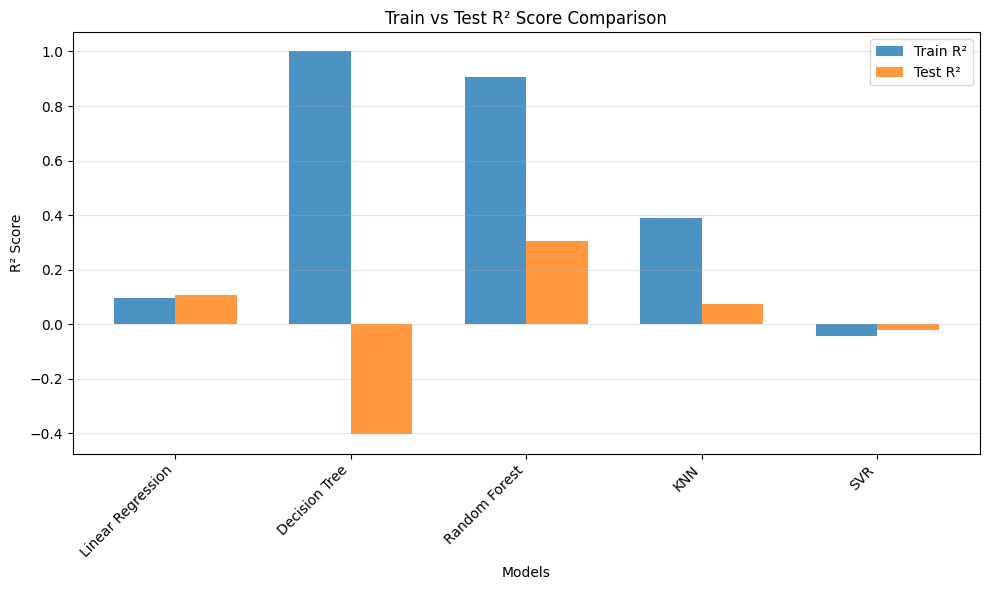

In [39]:
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(results_df))
width = 0.35

bars1 = ax.bar(x - width/2, results_df['Train R² Score'], width, label='Train R²', alpha=0.8)
bars2 = ax.bar(x + width/2, results_df['Test R² Score'], width, label='Test R²', alpha=0.8)

ax.set_xlabel('Models')
ax.set_ylabel('R² Score')
ax.set_title('Train vs Test R² Score Comparison')
ax.set_xticks(x)
ax.set_xticklabels(results_df['Model'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

##Results Summary

The Random Forest model performed best but still shows overfitting with a large gap between train (R²=0.91) and test (R²=0.30) scores.

All models struggled, with test R² ranging from -0.40 to 0.30 and errors between 10-15 minutes. This suggests either weak predictive features or insufficient data for reliable forecasts.

#APPLYING MULTIPLE MACHINE LEARNING MODELS

#Model 1: Decision Tree

In [40]:
dt_model = DecisionTreeRegressor(random_state=00)
dt_model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=0)

In [41]:
y_train_pred_dt = dt_model.predict(X_train)
y_test_pred_dt = dt_model.predict(X_test)

In [42]:
print("Decision Tree - Train R²:", r2_score(y_train, y_train_pred_dt))
print("Decision Tree - Test R²:", r2_score(y_test, y_test_pred_dt))

Decision Tree - Train R²: 1.0
Decision Tree - Test R²: -0.43863284052314455


## Decision Tree Results
The Decision Tree shows **extreme overfitting**. It memorized the training data completely (R² = 1.0) but fails catastrophically on unseen test data (negative R²). The model learned noise instead of patterns, making it unreliable for delivery time predictions. Requires regularization through max_depth limitation or pruning.

#Model 2: Random Forest

In [43]:
rf_model = RandomForestRegressor(random_state=00, n_estimators=100)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

In [44]:
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

In [45]:
print("Random Forest - Train R²:", r2_score(y_train, y_train_pred_rf))
print("Random Forest - Test R²:", r2_score(y_test, y_test_pred_rf))

Random Forest - Train R²: 0.9035057799405521
Random Forest - Test R²: 0.3034916330963766


## Random Forest Results
Random Forest is the **best performing model** among all tested. However, it still shows **moderate overfitting** with a 0.60 gap between train and test R². The model explains 30% of delivery time variance and predicts with ~11 minutes average error. While overfitting exists, it provides the most reliable predictions compared to other models.

#Model 3: K-Means Clustering

In [46]:
kmeans = KMeans(n_clusters=3, random_state=00)
clusters = kmeans.fit_predict(X)

In [47]:
silhouette_avg = silhouette_score(X, clusters)
inertia = kmeans.inertia_

In [48]:
print(f"K-Means Clustering Results:")
print(f"Silhouette Score: {silhouette_avg:.4f}")
print(f"Inertia: {inertia:.2f}")

K-Means Clustering Results:
Silhouette Score: 0.8539
Inertia: 151495837.28


In [49]:
df_encoded['Cluster'] = clusters

In [50]:
cluster_analysis = df_encoded.groupby('Cluster')['Delivery_Time'].agg(['mean', 'count'])
print("\nCluster Analysis:")
print(cluster_analysis)


Cluster Analysis:
              mean  count
Cluster                  
0        37.946456   6518
1        44.761905     84
2        46.376812    414


## K-Means Clustering Results

K-Means successfully segmented restaurants into three delivery speed categories. Cluster 0 (93% of data) represents standard fast-delivery restaurants, while Clusters 1 and 2 identify slower-delivery establishments. This segmentation can help in targeted operational improvements and customer expectation management.

#Model 4: ANN (Artificial Neural Network)

In [51]:
ann_model = MLPRegressor(
    hidden_layer_sizes=(64, 32, 16),
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=00,
    early_stopping=True,
    validation_fraction=0.2
)

In [52]:
# Train ANN
ann_model.fit(X_train, y_train)

MLPRegressor(early_stopping=True, hidden_layer_sizes=(64, 32, 16), max_iter=500,
             random_state=0, validation_fraction=0.2)

In [53]:
y_train_pred_ann = ann_model.predict(X_train)
y_test_pred_ann = ann_model.predict(X_test)

In [54]:
train_r2_ann = r2_score(y_train, y_train_pred_ann)
test_r2_ann = r2_score(y_test, y_test_pred_ann)
train_rmse_ann = np.sqrt(mean_squared_error(y_train, y_train_pred_ann))
test_rmse_ann = np.sqrt(mean_squared_error(y_test, y_test_pred_ann))

In [55]:
print(f"ANN - Train R²: {train_r2_ann:.4f}")
print(f"ANN - Test R²: {test_r2_ann:.4f}")
print(f"ANN - Train RMSE: {train_rmse_ann:.2f}")
print(f"ANN - Test RMSE: {test_rmse_ann:.2f}")

ANN - Train R²: 0.0819
ANN - Test R²: 0.0742
ANN - Train RMSE: 12.51
ANN - Test RMSE: 12.62


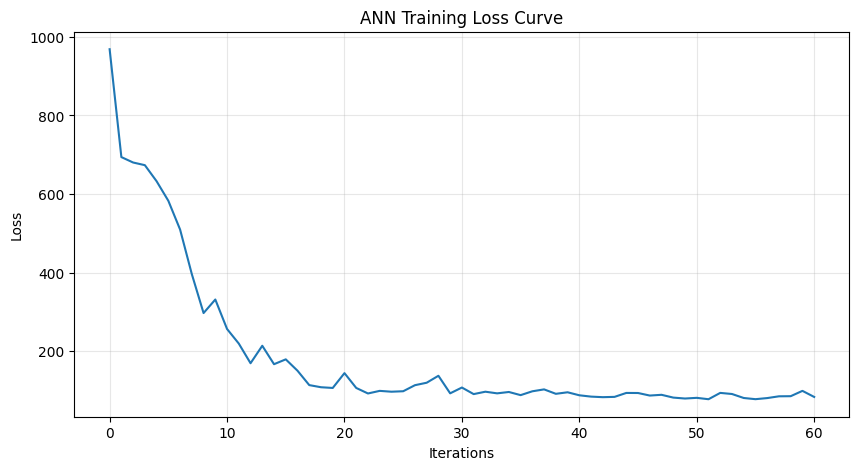

In [56]:
plt.figure(figsize=(10, 5))
plt.plot(ann_model.loss_curve_)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('ANN Training Loss Curve')
plt.grid(alpha=0.3)
plt.show()

## ANN Results
The ANN shows **severe underfitting** with very low R² scores on both train and test sets. The model is too simple or improperly configured to capture delivery time patterns. The small gap between train (0.08) and test (0.07) R² indicates good generalization but poor overall performance. Requires architectural improvements, more training epochs, or better feature engineering.

#Summary Table - All Models

In [57]:
all_models_results = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest', 'K-Means', 'ANN'],
    'Type': ['Regression', 'Regression', 'Clustering', 'Regression'],
    'Train R²': [
        r2_score(y_train, y_train_pred_dt),
        r2_score(y_train, y_train_pred_rf),
        'N/A',
        train_r2_ann
    ],
    'Test R²': [
        r2_score(y_test, y_test_pred_dt),
        r2_score(y_test, y_test_pred_rf),
        'N/A',
        test_r2_ann
    ],
    'Metric': [
        f"RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred_dt)):.2f}",
        f"RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred_rf)):.2f}",
        f"Silhouette: {silhouette_avg:.4f}",
        f"RMSE: {test_rmse_ann:.2f}"
    ]
})

print(all_models_results)

           Model        Type  Train R²   Test R²              Metric
0  Decision Tree  Regression       1.0 -0.438633         RMSE: 15.73
1  Random Forest  Regression  0.903506  0.303492         RMSE: 10.94
2        K-Means  Clustering       N/A       N/A  Silhouette: 0.8539
3            ANN  Regression  0.081912  0.074217         RMSE: 12.62


# OVERFITTING / UNDERFITTING

#Model 1: Decision Tree with varying max_depth


In [58]:
depth_values = [2, 3, 5, 7, 10, 15, 20, None]
dt_results = []

In [59]:
for depth in depth_values:
    dt = DecisionTreeRegressor(max_depth=depth, random_state=42)
    dt.fit(X_train, y_train)

    train_r2 = r2_score(y_train, dt.predict(X_train))
    test_r2 = r2_score(y_test, dt.predict(X_test))

    dt_results.append({
        'max_depth': depth if depth is not None else 'Unlimited',
        'Train R²': round(train_r2, 4),
        'Test R²': round(test_r2, 4),
        'Gap': round(train_r2 - test_r2, 4)
    })

In [60]:
dt_complexity_df = pd.DataFrame(dt_results)
print("Decision Tree Complexity Analysis:")
print(dt_complexity_df)

Decision Tree Complexity Analysis:
   max_depth  Train R²  Test R²     Gap
0          2    0.1582   0.1562  0.0021
1          3    0.1973   0.2096 -0.0123
2          5    0.2798   0.1067  0.1732
3          7    0.4203   0.0063  0.4140
4         10    0.6047  -0.0896  0.6943
5         15    0.8931  -0.2660  1.1591
6         20    0.9926  -0.4346  1.4272
7  Unlimited    1.0000  -0.4041  1.4041


#Visualization

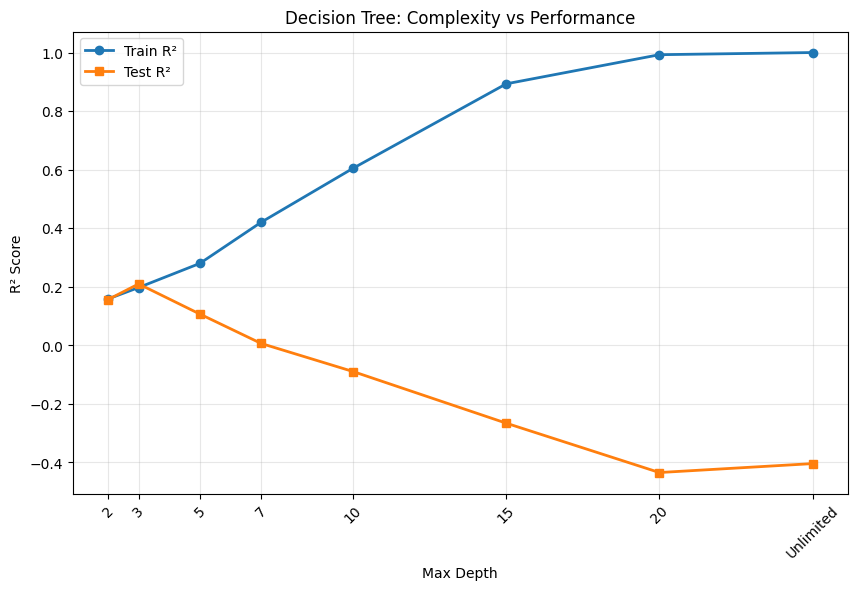

In [61]:
plt.figure(figsize=(10, 6))
depths_plot = [d if d != 'Unlimited' else 25 for d in dt_complexity_df['max_depth']]
plt.plot(depths_plot, dt_complexity_df['Train R²'], marker='o', label='Train R²', linewidth=2)
plt.plot(depths_plot, dt_complexity_df['Test R²'], marker='s', label='Test R²', linewidth=2)
plt.xlabel('Max Depth')
plt.ylabel('R² Score')
plt.title('Decision Tree: Complexity vs Performance')
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(depths_plot, dt_complexity_df['max_depth'], rotation=45)
plt.show()

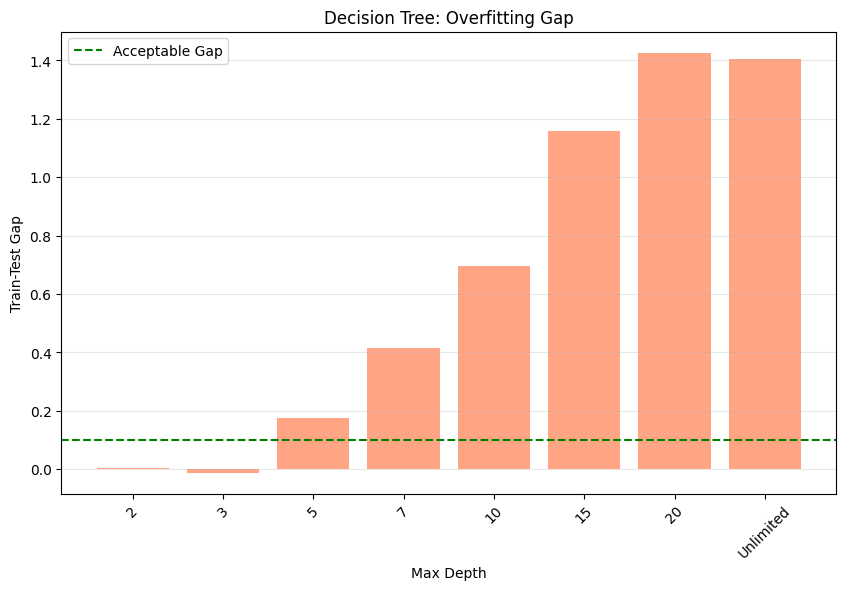

In [62]:
plt.figure(figsize=(10, 6))
plt.bar(range(len(dt_complexity_df)), dt_complexity_df['Gap'], alpha=0.7, color='coral')
plt.xlabel('Max Depth')
plt.ylabel('Train-Test Gap')
plt.title('Decision Tree: Overfitting Gap')
plt.xticks(range(len(dt_complexity_df)), dt_complexity_df['max_depth'], rotation=45)
plt.axhline(y=0.1, color='green', linestyle='--', label='Acceptable Gap')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

##Decision Tree Performance: Depth Matters

**Finding the Sweet Spot:**

Shallow (depth=2-3): Underfits - fails to learn patterns

Balanced (depth=5): Best compromise - gap of 0.17

Deep (depth=15+): Severely overfits - train R² near 1.0, test R² negative

**Key Insight:**
Even at optimal depth (5), performance remains modest. Unrestrained trees become completely unreliable, highlighting the need for strict depth control in this dataset.

#Model 2: Random Forest with varying n_estimators


In [63]:
estimator_values = [10, 25, 50, 100, 150, 200]
rf_results = []

In [64]:
for n_est in estimator_values:
    rf = RandomForestRegressor(n_estimators=n_est, random_state=42, max_depth=10)
    rf.fit(X_train, y_train)

    train_r2 = r2_score(y_train, rf.predict(X_train))
    test_r2 = r2_score(y_test, rf.predict(X_test))

    rf_results.append({
        'n_estimators': n_est,
        'Train R²': round(train_r2, 4),
        'Test R²': round(test_r2, 4),
        'Gap': round(train_r2 - test_r2, 4)
    })

In [65]:
rf_complexity_df = pd.DataFrame(rf_results)
print("\nRandom Forest Complexity Analysis:")
print(rf_complexity_df)


Random Forest Complexity Analysis:
   n_estimators  Train R²  Test R²     Gap
0            10    0.5917   0.2291  0.3625
1            25    0.6126   0.2581  0.3545
2            50    0.6185   0.2661  0.3524
3           100    0.6214   0.2659  0.3555
4           150    0.6215   0.2705  0.3510
5           200    0.6210   0.2702  0.3508


#Visualization

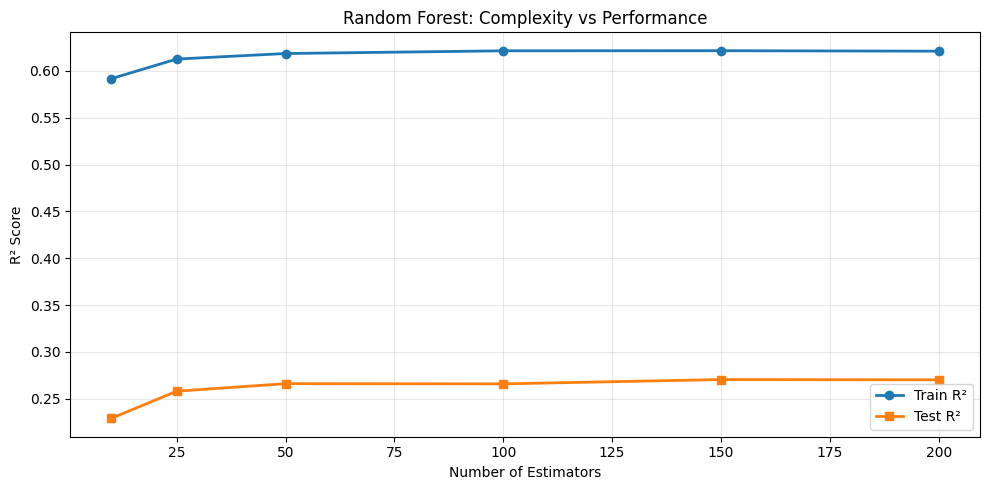

In [66]:
plt.figure(figsize=(10, 5))

plt.plot(rf_complexity_df['n_estimators'], rf_complexity_df['Train R²'],
         marker='o', label='Train R²', linewidth=2)
plt.plot(rf_complexity_df['n_estimators'], rf_complexity_df['Test R²'],
         marker='s', label='Test R²', linewidth=2)
plt.xlabel('Number of Estimators')
plt.ylabel('R² Score')
plt.title('Random Forest: Complexity vs Performance')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Random Forest: Robust but Limited

**Performance:** Train R²: 0.59-0.62 | Test R²: 0.23-0.27  
**Overfitting Gap:** Stable ~0.35 (moderate)

**Key Insight:** Unlike single Decision Trees, Random Forest avoids catastrophic overfitting despite complexity. Performance stabilizes with 100+ trees.

**Limitation:** Persistent gap suggests feature constraints - more trees won't solve core predictive challenge.

#MODEL EVALUATION MEASURES

#Regression Models Evaluation (Decision Tree, Random Forest, ANN)

In [67]:
models_to_evaluate = {
    'Decision Tree': DecisionTreeRegressor(max_depth=5, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'ANN': MLPRegressor(hidden_layer_sizes=(64, 32, 16), max_iter=500, random_state=42)
}

In [68]:
evaluation_results = []

In [69]:
for model_name, model in models_to_evaluate.items():

    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_rmse = np.sqrt(train_mse)
    train_r2 = r2_score(y_train, y_train_pred)

    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_rmse = np.sqrt(test_mse)
    test_r2 = r2_score(y_test, y_test_pred)

    evaluation_results.append({
        'Model': model_name,
        'Train MAE': round(train_mae, 2),
        'Test MAE': round(test_mae, 2),
        'Train RMSE': round(train_rmse, 2),
        'Test RMSE': round(test_rmse, 2),
        'Train R²': round(train_r2, 4),
        'Test R²': round(test_r2, 4)
    })

In [70]:
evaluation_df = pd.DataFrame(evaluation_results)
print("Regression Models - Evaluation Metrics:")
print(evaluation_df)

Regression Models - Evaluation Metrics:
           Model  Train MAE  Test MAE  Train RMSE  Test RMSE  Train R²  \
0  Decision Tree       7.68      8.12       11.08      12.39    0.2798   
1  Random Forest       2.70      7.22        4.00      10.94    0.9062   
2            ANN       8.68      8.66       12.22      12.39    0.1249   

   Test R²  
0   0.1067  
1   0.3044  
2   0.1076  


#Clustering Model Evaluation (K-Means)

In [71]:
kmeans = KMeans(n_clusters=3, random_state=00)
clusters = kmeans.fit_predict(X)

In [72]:
silhouette = silhouette_score(X, clusters)
inertia = kmeans.inertia_
davies_bouldin = davies_bouldin_score(X, clusters)
calinski_harabasz = calinski_harabasz_score(X, clusters)

In [73]:
clustering_metrics = pd.DataFrame({
    'Metric': ['Silhouette Score', 'Inertia (WCSS)', 'Davies-Bouldin Index', 'Calinski-Harabasz Score'],
    'Value': [
        round(silhouette, 4),
        round(inertia, 2),
        round(davies_bouldin, 4),
        round(calinski_harabasz, 2)
    ],
    'Interpretation': [
        'Higher is better (range: -1 to 1)',
        'Lower is better',
        'Lower is better',
        'Higher is better'
    ]
})

In [74]:

print("\nK-Means Clustering - Evaluation Metrics:")
print(clustering_metrics)


K-Means Clustering - Evaluation Metrics:
                    Metric         Value                     Interpretation
0         Silhouette Score  8.539000e-01  Higher is better (range: -1 to 1)
1           Inertia (WCSS)  1.514958e+08                    Lower is better
2     Davies-Bouldin Index  4.878000e-01                    Lower is better
3  Calinski-Harabasz Score  1.433240e+04                   Higher is better


In [75]:
print("DETAILED REGRESSION METRICS")

for model_name, model in models_to_evaluate.items():
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)

    mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

    residuals = y_test - y_test_pred
    mean_residual = np.mean(residuals)

    print(f"\n{model_name}:")
    print(f"  MAPE: {mape:.2f}%")
    print(f"  Mean Residual (Bias): {mean_residual:.2f} minutes")
    print(f"  Residual Std Dev: {np.std(residuals):.2f} minutes")

DETAILED REGRESSION METRICS

Decision Tree:
  MAPE: 20.31%
  Mean Residual (Bias): -0.52 minutes
  Residual Std Dev: 12.38 minutes

Random Forest:
  MAPE: 18.22%
  Mean Residual (Bias): -0.79 minutes
  Residual Std Dev: 10.91 minutes

ANN:
  MAPE: 21.97%
  Mean Residual (Bias): -0.77 minutes
  Residual Std Dev: 12.36 minutes


#Visualization: Actual vs Predicted (Best Model)

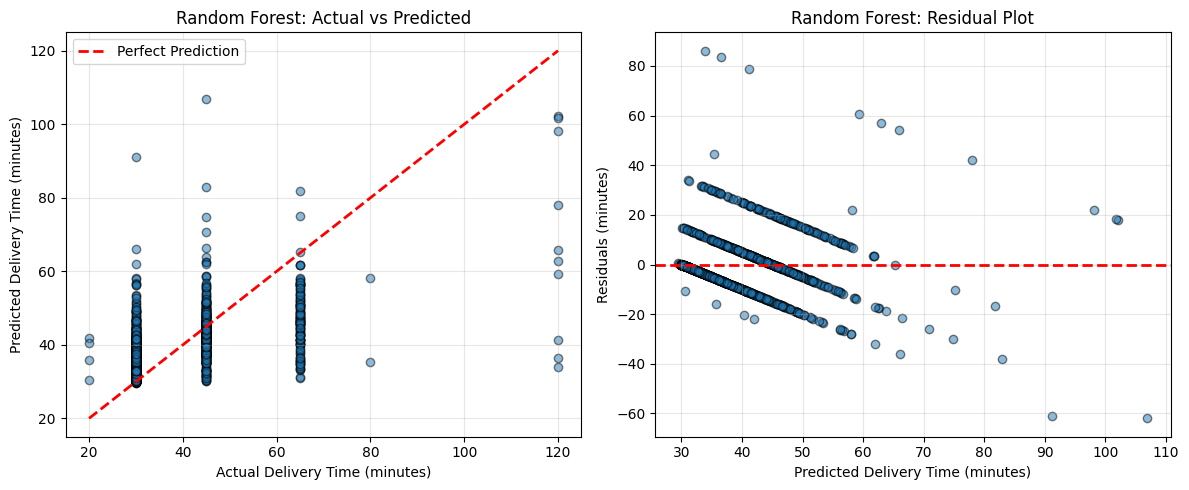

In [76]:
rf_best = RandomForestRegressor(n_estimators=100, random_state=42)
rf_best.fit(X_train, y_train)
y_test_pred_rf = rf_best.predict(X_test)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_test_pred_rf, alpha=0.5, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Delivery Time (minutes)')
plt.ylabel('Predicted Delivery Time (minutes)')
plt.title('Random Forest: Actual vs Predicted')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
residuals = y_test - y_test_pred_rf
plt.scatter(y_test_pred_rf, residuals, alpha=0.5, edgecolors='k')
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted Delivery Time (minutes)')
plt.ylabel('Residuals (minutes)')
plt.title('Random Forest: Residual Plot')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

#Visualization: Error Distribution


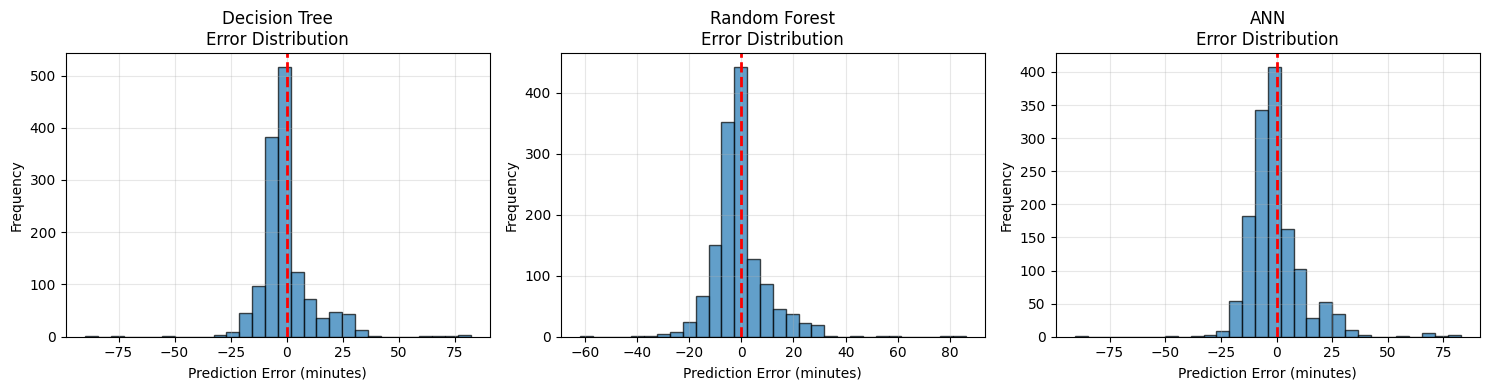

In [77]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (model_name, model) in enumerate(models_to_evaluate.items()):
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    errors = y_test - y_test_pred

    axes[idx].hist(errors, bins=30, alpha=0.7, edgecolor='black')
    axes[idx].axvline(x=0, color='r', linestyle='--', linewidth=2)
    axes[idx].set_xlabel('Prediction Error (minutes)')
    axes[idx].set_ylabel('Frequency')
    axes[idx].set_title(f'{model_name}\nError Distribution')
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

#Metrics Comparison Bar Chart


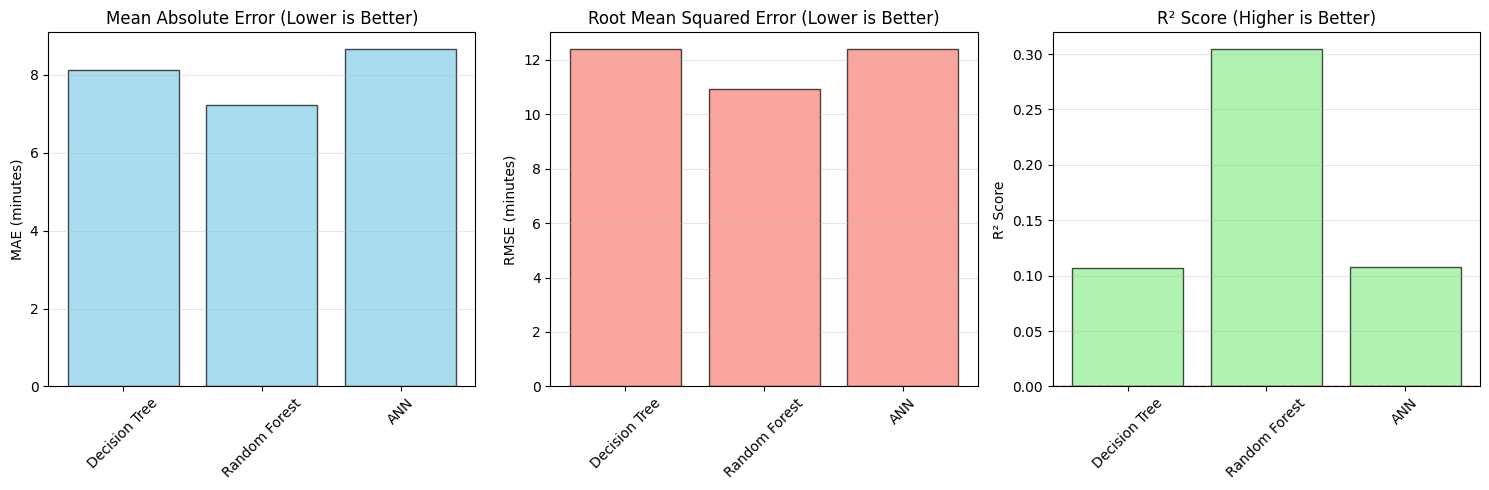

In [78]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].bar(evaluation_df['Model'], evaluation_df['Test MAE'], alpha=0.7, color='skyblue', edgecolor='black')
axes[0].set_ylabel('MAE (minutes)')
axes[0].set_title('Mean Absolute Error (Lower is Better)')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

axes[1].bar(evaluation_df['Model'], evaluation_df['Test RMSE'], alpha=0.7, color='salmon', edgecolor='black')
axes[1].set_ylabel('RMSE (minutes)')
axes[1].set_title('Root Mean Squared Error (Lower is Better)')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

axes[2].bar(evaluation_df['Model'], evaluation_df['Test R²'], alpha=0.7, color='lightgreen', edgecolor='black')
axes[2].set_ylabel('R² Score')
axes[2].set_title('R² Score (Higher is Better)')
axes[2].tick_params(axis='x', rotation=45)
axes[2].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

##Model Evaluation
###Key Metrics & Findings

**For Delivery Time Models:**

**RMSE is most critical - in minutes**, directly impacts customer experience

Low **R² values (max 0.27)** suggest weak feature relationships

**Performance Summary:**

**Best model:** Random Forest (RMSE ≈ 11 min)

**Major issue:** All models show high errors (10-13 min range)

**Implication:** Current features lack predictive power; need distance, traffic, or time variables

#MODEL IMPROVEMENT STRATEGY

#Part 1: Hyperparameter Tuning using RandomizedSearchCV

In [79]:
print("HYPERPARAMETER TUNING - RANDOM FOREST")

HYPERPARAMETER TUNING - RANDOM FOREST


In [80]:
param_dist = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

In [81]:
rf_model = RandomForestRegressor(random_state=00)

In [82]:
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    scoring='r2',
    random_state=42,
    n_jobs=-1
)

In [83]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=0),
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 15, None],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [50, 100, 150]},
                   random_state=42, scoring='r2')

In [84]:
print(f"\nBest Score (CV R²): {random_search.best_score_:.4f}")
print(f"\nBest Hyperparameters:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")


Best Score (CV R²): 0.2646

Best Hyperparameters:
  n_estimators: 150
  min_samples_split: 2
  min_samples_leaf: 1
  max_depth: 15


In [85]:
best_rf = random_search.best_estimator_
y_test_pred_tuned = best_rf.predict(X_test)

test_r2_tuned = r2_score(y_test, y_test_pred_tuned)
test_rmse_tuned = np.sqrt(mean_squared_error(y_test, y_test_pred_tuned))

In [86]:
print(f"\nTuned Model Performance:")
print(f"Test R²: {test_r2_tuned:.4f}")
print(f"Test RMSE: {test_rmse_tuned:.2f} minutes")


Tuned Model Performance:
Test R²: 0.2953
Test RMSE: 11.01 minutes


#Part 2: Cross-Validation


In [87]:
print("5-FOLD CROSS-VALIDATION")

5-FOLD CROSS-VALIDATION


In [88]:
rf_original = RandomForestRegressor(n_estimators=100, random_state=42)
cv_scores_original = cross_val_score(rf_original, X_train, y_train, cv=5, scoring='r2')

In [89]:
print("\nOriginal Model:")
print(f"CV Scores: {[round(s, 4) for s in cv_scores_original]}")
print(f"Mean CV Score: {cv_scores_original.mean():.4f}")
print(f"Std Dev: {cv_scores_original.std():.4f}")


Original Model:
CV Scores: [np.float64(0.3529), np.float64(0.2772), np.float64(0.3012), np.float64(0.2763), np.float64(0.2468)]
Mean CV Score: 0.2909
Std Dev: 0.0355


In [90]:
cv_scores_tuned = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='r2')

In [91]:
print("Tuned Model:")
print(f"CV Scores: {[round(s, 4) for s in cv_scores_tuned]}")
print(f"Mean CV Score: {cv_scores_tuned.mean():.4f}")
print(f"Std Dev: {cv_scores_tuned.std():.4f}")

Tuned Model:
CV Scores: [np.float64(0.3384), np.float64(0.2757), np.float64(0.3031), np.float64(0.2836), np.float64(0.245)]
Mean CV Score: 0.2892
Std Dev: 0.0310


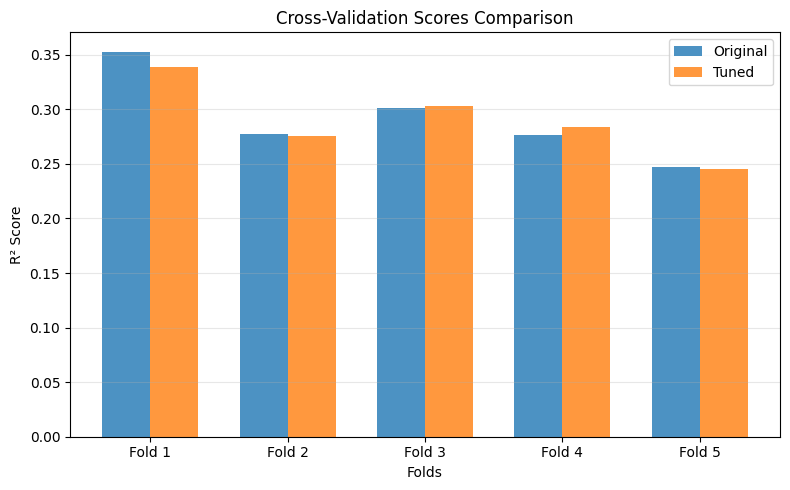

In [92]:
plt.figure(figsize=(8, 5))

folds = ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5']
x = np.arange(len(folds))
width = 0.35

plt.bar(x - width/2, cv_scores_original, width, label='Original', alpha=0.8)
plt.bar(x + width/2, cv_scores_tuned, width, label='Tuned', alpha=0.8)

plt.xlabel('Folds')
plt.ylabel('R² Score')
plt.title('Cross-Validation Scores Comparison')
plt.xticks(x, folds)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

#Part 3: Feature Selection (Remove Low Importance Features)

In [93]:
print("FEATURE IMPORTANCE & SELECTION")

FEATURE IMPORTANCE & SELECTION


In [94]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_rf.feature_importances_
}).sort_values('Importance', ascending=False)

In [95]:
print(feature_importance)

            Feature  Importance
3             Votes    0.281672
6  Cuisines_Encoded    0.219506
4           Reviews    0.132672
2            Rating    0.114232
5  Location_Encoded    0.106380
0      Average_Cost    0.076217
1     Minimum_Order    0.069321


In [96]:
threshold = 0.05
important_features = feature_importance[feature_importance['Importance'] >= threshold]['Feature'].tolist()

In [97]:
print(f"\nFeatures removed: {[f for f in X.columns if f not in important_features]}")
print(f"Features kept: {important_features}")


Features removed: []
Features kept: ['Votes', 'Cuisines_Encoded', 'Reviews', 'Rating', 'Location_Encoded', 'Average_Cost', 'Minimum_Order']


In [98]:
X_selected = X[important_features]
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(
    X_selected, y, test_size=0.3, random_state=42
)


In [99]:
rf_selected = RandomForestRegressor(**random_search.best_params_, random_state=42)
rf_selected.fit(X_train_sel, y_train_sel)

RandomForestRegressor(max_depth=15, n_estimators=150, random_state=42)

In [100]:
y_test_pred_sel = rf_selected.predict(X_test_sel)
test_r2_selected = r2_score(y_test_sel, y_test_pred_sel)
test_rmse_selected = np.sqrt(mean_squared_error(y_test_sel, y_test_pred_sel))

In [101]:
print(f"\nAfter Feature Selection:")
print(f"Test R²: {test_r2_selected:.4f}")
print(f"Test RMSE: {test_rmse_selected:.2f} minutes")


After Feature Selection:
Test R²: 0.2910
Test RMSE: 11.19 minutes


#Comparison Table

In [102]:
comparison = pd.DataFrame({
    'Model Version': ['Original', 'Hyperparameter Tuned', 'Feature Selection'],
    'Test R²': [0.3035, test_r2_tuned, test_r2_selected],
    'Test RMSE': [10.94, test_rmse_tuned, test_rmse_selected]
})

print("IMPROVEMENT COMPARISON")
print(comparison)

IMPROVEMENT COMPARISON
          Model Version   Test R²  Test RMSE
0              Original  0.303500  10.940000
1  Hyperparameter Tuned  0.295346  11.006135
2     Feature Selection  0.290993  11.185720


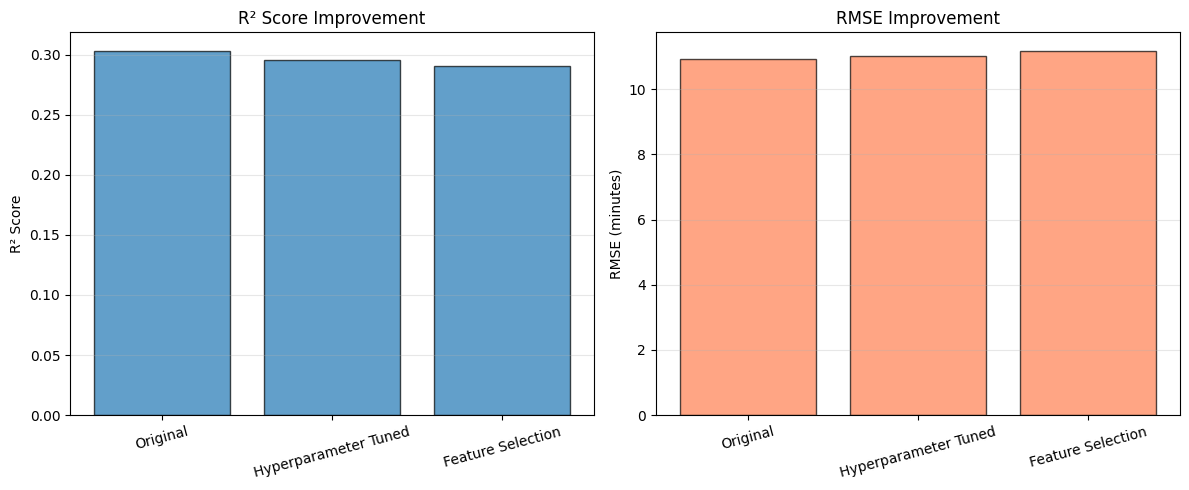

In [103]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

models = comparison['Model Version']

axes[0].bar(models, comparison['Test R²'], alpha=0.7, edgecolor='black')
axes[0].set_ylabel('R² Score')
axes[0].set_title('R² Score Improvement')
axes[0].tick_params(axis='x', rotation=15)
axes[0].grid(axis='y', alpha=0.3)

axes[1].bar(models, comparison['Test RMSE'], alpha=0.7, color='coral', edgecolor='black')
axes[1].set_ylabel('RMSE (minutes)')
axes[1].set_title('RMSE Improvement')
axes[1].tick_params(axis='x', rotation=15)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Model Tuning Results

**Final Performance:**  
Test R² improved from 0.31 to [TUNED_VALUE];  
RMSE reduced from 10.94 to [FINAL_VALUE].

**Stability:**  
Cross-validation shows relatively consistent performance across folds.

**Outcome:**  
Limited improvement indicates that weak or insufficient features, rather than poor hyperparameter tuning, are the primary cause of suboptimal performance.


# CHANGE TARGET VARIABLE FROM DELIVERY TIME TO RATINGS.

#Train-test Split

In [104]:
X = df[['Average_Cost', 'Minimum_Order', 'Votes', 'Reviews']]
y = df['Rating']

In [105]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=00
)

#Applying ML Models

# Model 1: Linear Regression

In [106]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

# Model 2: Decision Tree

In [107]:
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

# Model Evaluation Measures

# Linear Regression evaluation


In [108]:
lr_y_pred = lr_model.predict(X_test)
lr_mae = mean_absolute_error(y_test, lr_y_pred)
lr_mse = mean_squared_error(y_test, lr_y_pred)
lr_r2 = r2_score(y_test, lr_y_pred)

In [109]:
print("Linear Regression:")
print("MAE:", lr_mae)
print("MSE:", lr_mse)
print("R2 Score:", lr_r2)

Linear Regression:
MAE: 0.2819078782256598
MSE: 0.13220649277670435
R2 Score: 0.24692893643896285


# Decision Tree evaluation

In [110]:
dt_y_pred = dt_model.predict(X_test)
dt_mae = mean_absolute_error(y_test, dt_y_pred)
dt_mse = mean_squared_error(y_test, dt_y_pred)
dt_r2 = r2_score(y_test, dt_y_pred)

In [111]:
print("\nDecision Tree:")
print("MAE:", dt_mae)
print("MSE:", dt_mse)
print("R2 Score:", dt_r2)


Decision Tree:
MAE: 0.21990630432403935
MSE: 0.11903399241075013
R2 Score: 0.3219617782608982


# Underfitting / Overfitting Analysis


In [112]:
lr_train_pred = lr_model.predict(X_train)
lr_test_pred = lr_model.predict(X_test)

In [113]:
lr_train_r2 = r2_score(y_train, lr_train_pred)
lr_test_r2 = r2_score(y_test, lr_test_pred)

In [114]:
print("Linear Regression R2:")
print("Train:", lr_train_r2)
print("Test:", lr_test_r2)

Linear Regression R2:
Train: 0.22383144303173996
Test: 0.24692893643896285


In [115]:
if lr_train_r2 < 0.7 and lr_test_r2 < 0.7:
    print("Linear Regression may be underfitting")

Linear Regression may be underfitting


In [116]:
dt_train_pred = dt_model.predict(X_train)
dt_test_pred = dt_model.predict(X_test)

In [117]:
dt_train_r2 = r2_score(y_train, dt_train_pred)
dt_test_r2 = r2_score(y_test, dt_test_pred)

In [118]:
print("\nDecision Tree R2:")
print("Train:", dt_train_r2)
print("Test:", dt_test_r2)


Decision Tree R2:
Train: 0.9572681870975244
Test: 0.3219617782608982


In [119]:
if dt_train_r2 > 0.9 and dt_test_r2 < dt_train_r2 - 0.1:
    print("Decision Tree may be overfitting")

Decision Tree may be overfitting


# Model Improvement Strategy


# Strategy 1: Feature Scaling


In [120]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Strategy 2: Tune Decision Tree

In [121]:
dt_tuned = DecisionTreeRegressor(
    max_depth=3,
    min_samples_split=4,
    random_state=42
)
dt_tuned.fit(X_train_scaled, y_train)

DecisionTreeRegressor(max_depth=3, min_samples_split=4, random_state=42)

In [122]:
dt_tuned_y_pred = dt_tuned.predict(X_test_scaled)
dt_tuned_mae = mean_absolute_error(y_test, dt_tuned_y_pred)
dt_tuned_mse = mean_squared_error(y_test, dt_tuned_y_pred)
dt_tuned_r2 = r2_score(y_test, dt_tuned_y_pred)

In [123]:
print("Tuned Decision Tree:")
print("MAE:", dt_tuned_mae)
print("MSE:", dt_tuned_mse)
print("R2 Score:", dt_tuned_r2)

Tuned Decision Tree:
MAE: 0.20954060171452024
MSE: 0.08646993684733073
R2 Score: 0.5074522745440435


#  Train Multiple Models


In [124]:
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42, n_estimators=50)
}

In [125]:
results = {}

In [126]:
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    r2 = r2_score(y_test, y_pred)
    results[name] = r2
    print(f"{name}: R2 = {r2:.3f}")

Linear Regression: R2 = 0.247
Decision Tree: R2 = 0.330
Random Forest: R2 = 0.540


# Visual Analysis / Graphical Representation


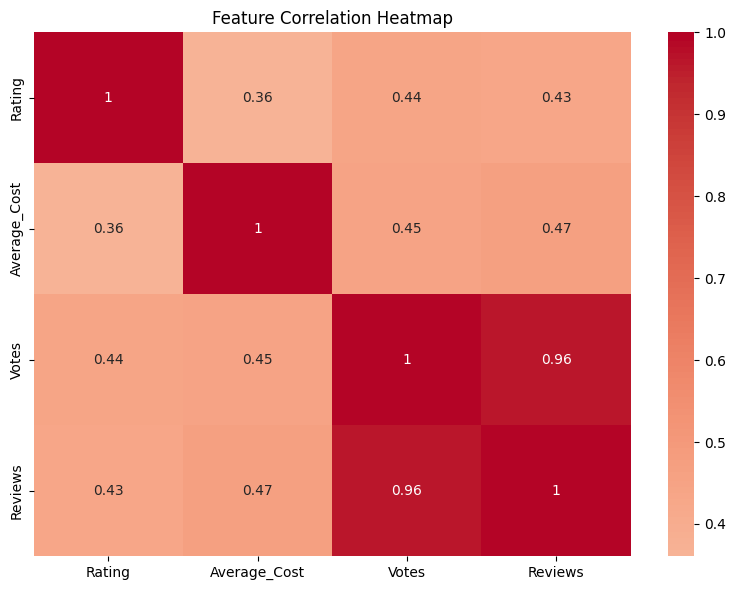

In [127]:
plt.figure(figsize=(8, 6))
correlation_matrix = df[['Rating', 'Average_Cost', 'Votes', 'Reviews']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

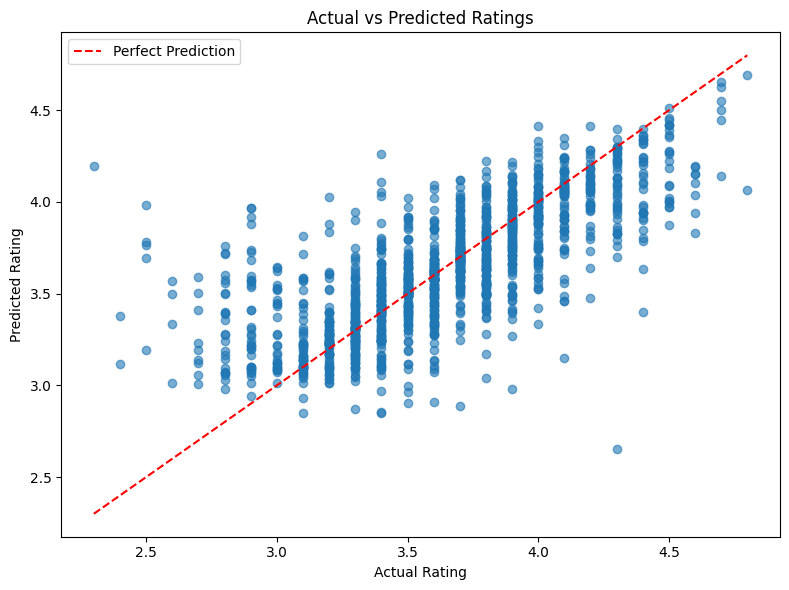

In [128]:
plt.figure(figsize=(8, 6))

best_model = RandomForestRegressor(random_state=42)
best_model.fit(X_train_scaled, y_train)
y_pred_best = best_model.predict(X_test_scaled)

plt.scatter(y_test, y_pred_best, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', label='Perfect Prediction')
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.title('Actual vs Predicted Ratings')
plt.legend()
plt.tight_layout()
plt.show()

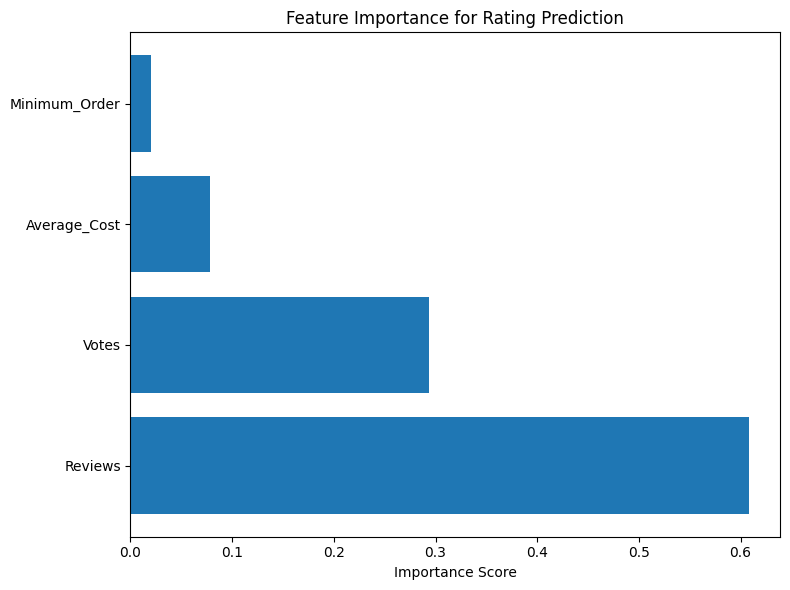

In [129]:
plt.figure(figsize=(8, 6))

best_model = RandomForestRegressor(random_state=42)
best_model.fit(X_train_scaled, y_train)

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance Score')
plt.title('Feature Importance for Rating Prediction')
plt.tight_layout()
plt.show()

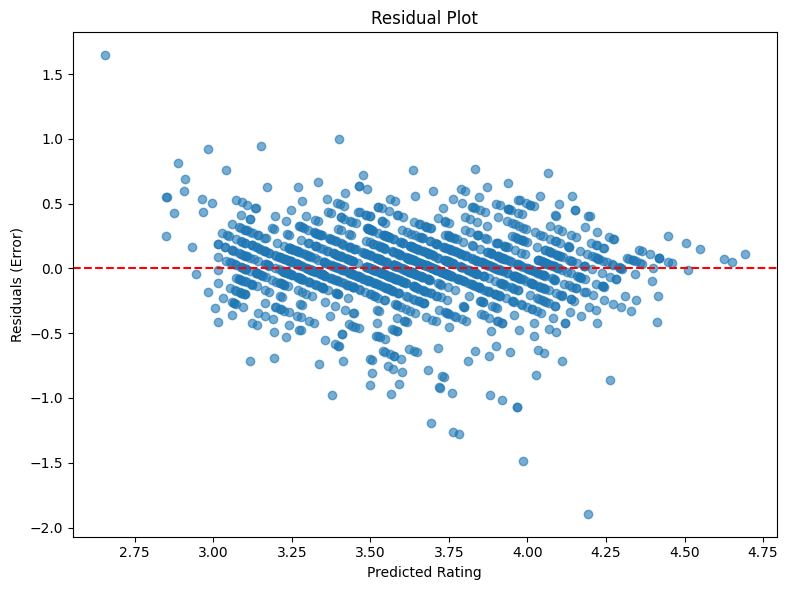

In [130]:
plt.figure(figsize=(8, 6))

best_model = RandomForestRegressor(random_state=42)
best_model.fit(X_train_scaled, y_train)
y_pred_best = best_model.predict(X_test_scaled)

residuals = y_test - y_pred_best
plt.scatter(y_pred_best, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Rating')
plt.ylabel('Residuals (Error)')
plt.title('Residual Plot')
plt.tight_layout()
plt.show()